In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, classification_report
from sentence_transformers import SentenceTransformer
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import LabelEncoder

# Load data
data = pd.read_csv('D:/fake reviews dataset.csv')

# Basic data exploration
print(data.head())
print(data.info())



             category  rating label  \
0  Home_and_Kitchen_5     5.0    CG   
1  Home_and_Kitchen_5     5.0    CG   
2  Home_and_Kitchen_5     5.0    CG   
3  Home_and_Kitchen_5     1.0    CG   
4  Home_and_Kitchen_5     5.0    CG   

                                               text_  
0  Love this!  Well made, sturdy, and very comfor...  
1  love it, a great upgrade from the original.  I...  
2  This pillow saved my back. I love the look and...  
3  Missing information on how to use it, but it i...  
4  Very nice set. Good quality. We have had the s...  
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 40432 entries, 0 to 40431
Data columns (total 4 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   category  40432 non-null  object 
 1   rating    40432 non-null  float64
 2   label     40432 non-null  object 
 3   text_     40432 non-null  object 
dtypes: float64(1), object(3)
memory usage: 1.2+ MB
None


In [2]:
# Create a DataFrame
df = pd.DataFrame(data)
df

,category,rating,label,text_
0,Home_and_Kitchen_5,5.0,CG,"Love this! Well made, sturdy, and very comfor..."
1,Home_and_Kitchen_5,5.0,CG,"love it, a great upgrade from the original. I..."
2,Home_and_Kitchen_5,5.0,CG,This pillow saved my back. I love the look and...
3,Home_and_Kitchen_5,1.0,CG,"Missing information on how to use it, but it i..."
4,Home_and_Kitchen_5,5.0,CG,Very nice set. Good quality. We have had the s...
...,...,...,...,...
40427,Clothing_Shoes_and_Jewelry_5,4.0,OR,I had read some reviews saying that this bra r...
40428,Clothing_Shoes_and_Jewelry_5,5.0,CG,I wasn't sure exactly what it would be. It is ...
40429,Clothing_Shoes_and_Jewelry_5,2.0,OR,"You can wear the hood by itself, wear it with ..."
40430,Clothing_Shoes_and_Jewelry_5,1.0,CG,I liked nothing about this dress. The only rea...


In [3]:

# Initialize the Sentence-BERT model
model = SentenceTransformer('all-MiniLM-L6-v2')

# Preprocess and clean the text column
def preprocess_text(text):
    text = text.lower()
    return text

df['cleaned_text'] = df['text_'].apply(preprocess_text)

# Compute embeddings for all reviews
embeddings = model.encode(df['cleaned_text'].tolist(), show_progress_bar=True)

# Optional: Calculate similarity between reviews (for detecting duplicates)
cosine_sim_matrix = cosine_similarity(embeddings)

# Define a similarity threshold (for flagging duplicates)
similarity_threshold = 0.85
duplicate_pairs = []

for i in range(len(cosine_sim_matrix)):
    for j in range(i + 1, len(cosine_sim_matrix)):
        if cosine_sim_matrix[i][j] > similarity_threshold:
            duplicate_pairs.append((i, j, cosine_sim_matrix[i][j]))
            

# Flag duplicate reviews
df['fake_review_flag'] = 0  # Default value
for i, j, sim_score in duplicate_pairs:
    df.at[i, 'fake_review_flag'] = 1
    df.at[j, 'fake_review_flag'] = 1

# Optional: Show duplicate review pairs and similarity scores
for i, j, sim_score in duplicate_pairs:
    print(f"Duplicate reviews detected between row {i} and row {j} with similarity {sim_score:.2f}")









Batches:   0%|          | 0/1264 [00:00<?, ?it/s]

Duplicate reviews detected between row 4 and row 795 with similarity 0.87
Duplicate reviews detected between row 4 and row 897 with similarity 0.88
Duplicate reviews detected between row 19 and row 1867 with similarity 0.87
Duplicate reviews detected between row 23 and row 213 with similarity 0.88
Duplicate reviews detected between row 23 and row 329 with similarity 0.86
Duplicate reviews detected between row 37 and row 966 with similarity 0.87
Duplicate reviews detected between row 44 and row 4081 with similarity 0.85
Duplicate reviews detected between row 71 and row 100 with similarity 0.89
Duplicate reviews detected between row 126 and row 1144 with similarity 0.95
Duplicate reviews detected between row 126 and row 1488 with similarity 0.94
Duplicate reviews detected between row 132 and row 1355 with similarity 0.93
Duplicate reviews detected between row 132 and row 2278 with similarity 0.86
Duplicate reviews detected between row 138 and row 1065 with similarity 0.93
Duplicate revie

In [4]:

# Encoding the target variable ('label') for classification
encoder = LabelEncoder()
# Map 'CG' and 'OR' to 'Real' and 'Fake'
df['encoded_label'] = encoder.fit_transform(df['label'])
    

In [5]:
# Prepare features (embeddings) and target variable (encoded labels)
X_embeddings = np.array(embeddings)
X_duplicate_flag = df[['fake_review_flag']].values  # Duplicate flag
# Combine both features
X = np.hstack([X_embeddings, X_duplicate_flag])
y = df['encoded_label']

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Train a classifier (Logistic Regression in this case)
classifier = LogisticRegression(max_iter=1000)
classifier.fit(X_train, y_train)

# Make predictions
y_pred = classifier.predict(X_test)


In [6]:

# Preview the final dataset with predictions
print(df[['category', 'rating', 'label', 'text_', 'fake_review_flag']].head())

             category  rating label  \
0  Home_and_Kitchen_5     5.0    CG   
1  Home_and_Kitchen_5     5.0    CG   
2  Home_and_Kitchen_5     5.0    CG   
3  Home_and_Kitchen_5     1.0    CG   
4  Home_and_Kitchen_5     5.0    CG   

                                               text_  fake_review_flag  
0  Love this!  Well made, sturdy, and very comfor...                 0  
1  love it, a great upgrade from the original.  I...                 0  
2  This pillow saved my back. I love the look and...                 0  
3  Missing information on how to use it, but it i...                 0  
4  Very nice set. Good quality. We have had the s...                 1  


In [7]:
# Evaluate the model
print("Classification Report:")
print(classification_report(y_test, y_pred, target_names=encoder.classes_))

# Save the final predictions and flags
df['predicted_fake_flag'] = classifier.predict(X)

# Save the dataframe with the predictions
df.to_csv('reviews_with_predictions.csv', index=False)

Classification Report:
              precision    recall  f1-score   support

          CG       0.81      0.80      0.80      4016
          OR       0.81      0.81      0.81      4071

    accuracy                           0.81      8087
   macro avg       0.81      0.81      0.81      8087
weighted avg       0.81      0.81      0.81      8087



In [8]:
print("Classification Report:")
print(classification_report(y_test, y_pred, target_names=['Fake', 'Real']))

Classification Report:
              precision    recall  f1-score   support

        Fake       0.81      0.80      0.80      4016
        Real       0.81      0.81      0.81      4071

    accuracy                           0.81      8087
   macro avg       0.81      0.81      0.81      8087
weighted avg       0.81      0.81      0.81      8087



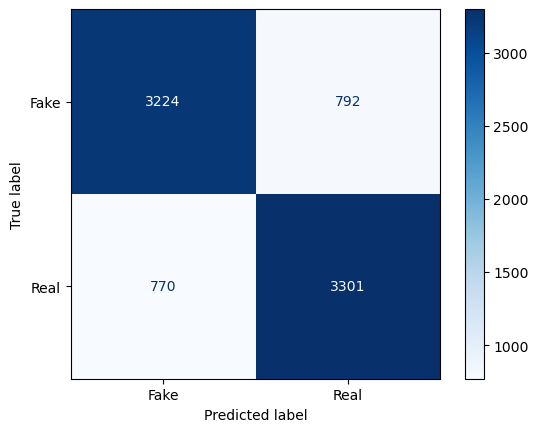

In [9]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# Compute the confusion matrix
cm = confusion_matrix(y_test, y_pred, labels=classifier.classes_)

# Display the confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['Fake', 'Real'])
disp.plot(cmap='Blues', values_format='d')


In [10]:
# Count the number of fake and real reviews
real_reviews_count = df[df['label'] == 'CG'].shape[0]  # Count real reviews (CG)
fake_reviews_count = df[df['label'] == 'OR'].shape[0]  # Count fake reviews (OR)

# Print the counts
print(f"Number of real reviews: {real_reviews_count}")
print(f"Number of fake reviews: {fake_reviews_count}")


Number of real reviews: 20216
Number of fake reviews: 20216


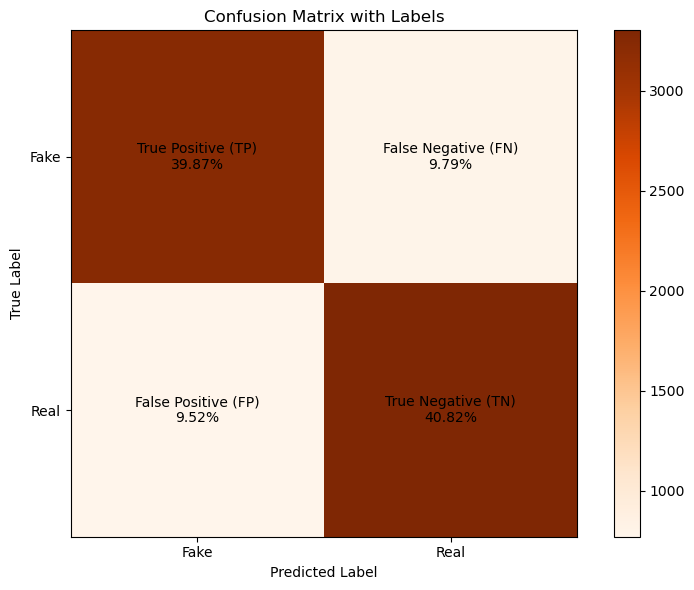

In [11]:
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import confusion_matrix

# Compute the confusion matrix
cm = confusion_matrix(y_test, y_pred, labels=classifier.classes_)
cm_percentage = cm / cm.sum() * 100  # Normalize to percentages

# Map class names ('Fake' and 'Real') to your labels
class_names = ['Fake', 'Real']

# Custom labels for confusion matrix cells
cell_labels = np.array([
    ["True Positive (TP)", "False Negative (FN)"],
    ["False Positive (FP)", "True Negative (TN)"]
])

# Create a plot
fig, ax = plt.subplots(figsize=(8, 6))
im = ax.imshow(cm, interpolation='nearest', cmap='Oranges')

# Add titles and labels
ax.set_title("Confusion Matrix with Labels")
ax.set_xticks(np.arange(len(class_names)))
ax.set_yticks(np.arange(len(class_names)))
ax.set_xticklabels(class_names)
ax.set_yticklabels(class_names)
ax.set_xlabel("Predicted Label")
ax.set_ylabel("True Label")

# Annotate each cell with the confusion matrix percentage and its label
for i in range(cm_percentage.shape[0]):
    for j in range(cm_percentage.shape[1]):
        ax.text(j, i, f"{cell_labels[i, j]}\n{cm_percentage[i, j]:.2f}%", 
                ha="center", va="center", color="black", fontsize=10)

# Add a color bar
plt.colorbar(im)
plt.tight_layout()
plt.show()


Classification Report:
              precision    recall  f1-score   support

        Fake       0.81      0.80      0.80      4016
        Real       0.81      0.81      0.81      4071

    accuracy                           0.81      8087
   macro avg       0.81      0.81      0.81      8087
weighted avg       0.81      0.81      0.81      8087



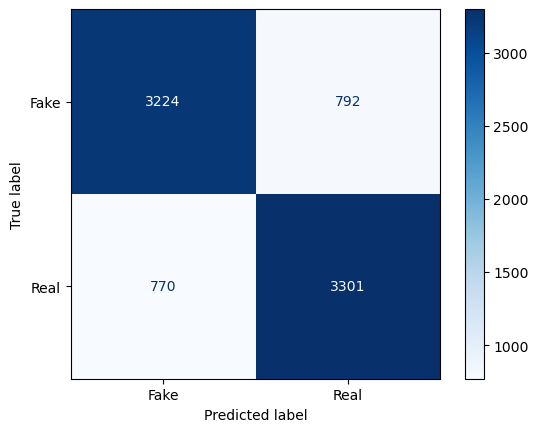

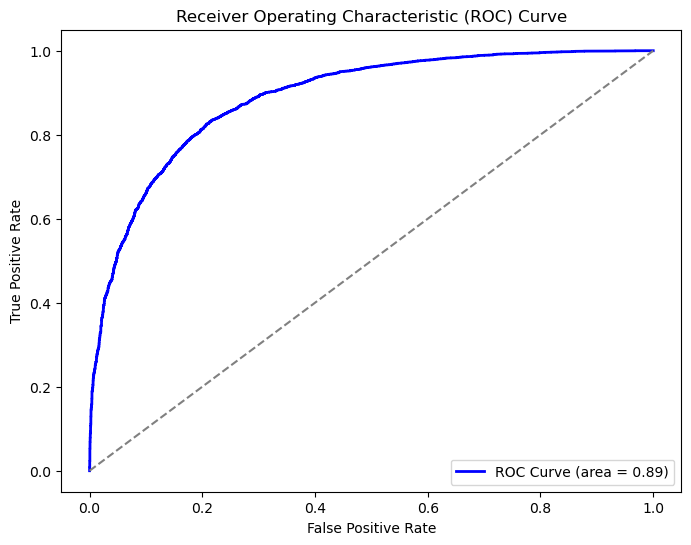

c:\Users\jitu1\anaconda3\Lib\site-packages\sklearn\linear_model\_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
c:\Users\jitu1\anaconda3\Lib\site-packages\sklearn\linear_model\_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_

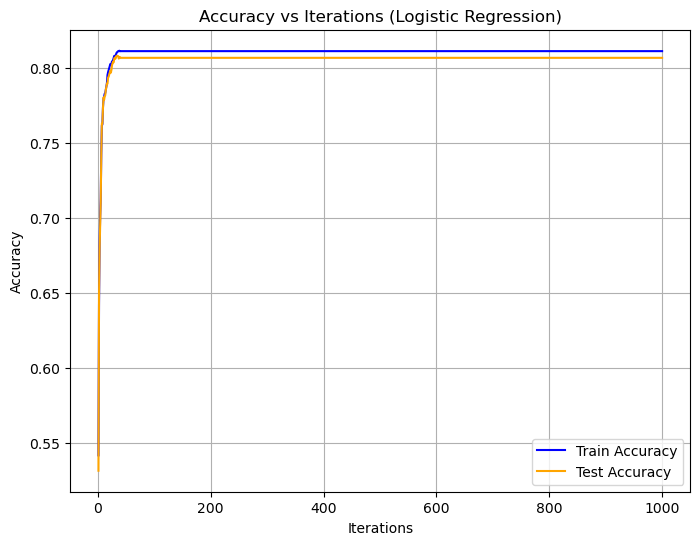

In [12]:
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix

# Train a classifier (Logistic Regression in this case)
classifier = LogisticRegression(max_iter=1000)
classifier.fit(X_train, y_train)

# Make predictions
y_pred = classifier.predict(X_test)

# Evaluate the model
print("Classification Report:")
print(classification_report(y_test, y_pred, target_names=['Fake', 'Real']))

# Compute the confusion matrix
cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['Fake', 'Real'])
disp.plot(cmap='Blues', values_format='d')
plt.show()

# Plotting ROC Curve
fpr, tpr, thresholds = roc_curve(y_test, classifier.predict_proba(X_test)[:,1])
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='blue', lw=2, label=f'ROC Curve (area = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='gray', linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.show()

# Plotting Accuracy vs Iteration (Training Process)
# Since Logistic Regression doesn't have built-in accuracy tracking during training, 
# you can do this manually by using the training process or tracking progress for each iteration.
# Here, we will use a simple approach to visualize accuracy over iterations manually

iterations = range(1, 1001)  # max_iter=1000
train_accuracies = []
test_accuracies = []

# Reinitialize classifier to track accuracy over iterations
for i in iterations:
    classifier = LogisticRegression(max_iter=i)
    classifier.fit(X_train, y_train)
    
    # Accuracy at each iteration
    train_accuracies.append(classifier.score(X_train, y_train))
    test_accuracies.append(classifier.score(X_test, y_test))

# Plot accuracy vs. iterations
plt.figure(figsize=(8, 6))
plt.plot(iterations, train_accuracies, label='Train Accuracy', color='blue')
plt.plot(iterations, test_accuracies, label='Test Accuracy', color='orange')
plt.xlabel('Iterations')
plt.ylabel('Accuracy')
plt.title('Accuracy vs Iterations (Logistic Regression)')
plt.legend()
plt.grid(True)
plt.show()


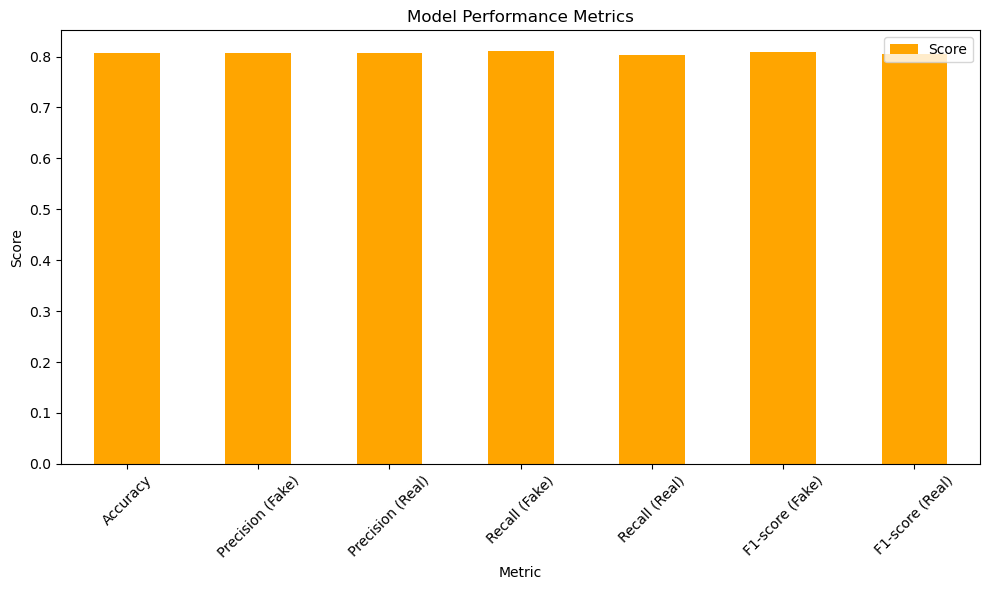

In [13]:
import matplotlib.pyplot as plt
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score

# Calculate the metrics
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred, average=None)
recall = recall_score(y_test, y_pred, average=None)
f1 = f1_score(y_test, y_pred, average=None)

# Create a DataFrame for easy visualization
metrics_df = pd.DataFrame({
    'Metric': ['Accuracy', 'Precision (Fake)', 'Precision (Real)', 'Recall (Fake)', 'Recall (Real)', 'F1-score (Fake)', 'F1-score (Real)'],
    'Score': [accuracy, precision[1], precision[0], recall[1], recall[0], f1[1], f1[0]]
})

# Plot the metrics
metrics_df.set_index('Metric').plot(kind='bar', color=['orange', 'blue', 'green', 'red', 'purple', 'brown', 'cyan'], figsize=(10, 6))
plt.title('Model Performance Metrics')
plt.ylabel('Score')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


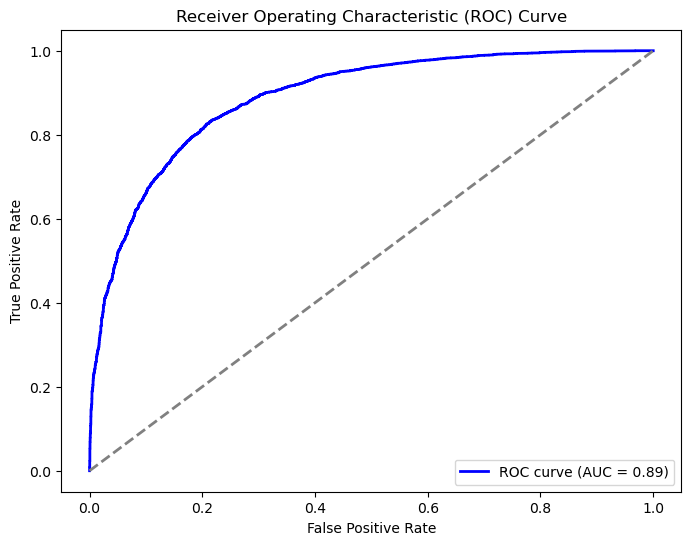

In [14]:
from sklearn.metrics import roc_curve, auc

# Compute ROC curve and AUC
fpr, tpr, thresholds = roc_curve(y_test, classifier.predict_proba(X_test)[:, 1])
roc_auc = auc(fpr, tpr)

# Plot ROC curve
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='blue', lw=2, label=f'ROC curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='gray', lw=2, linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.show()


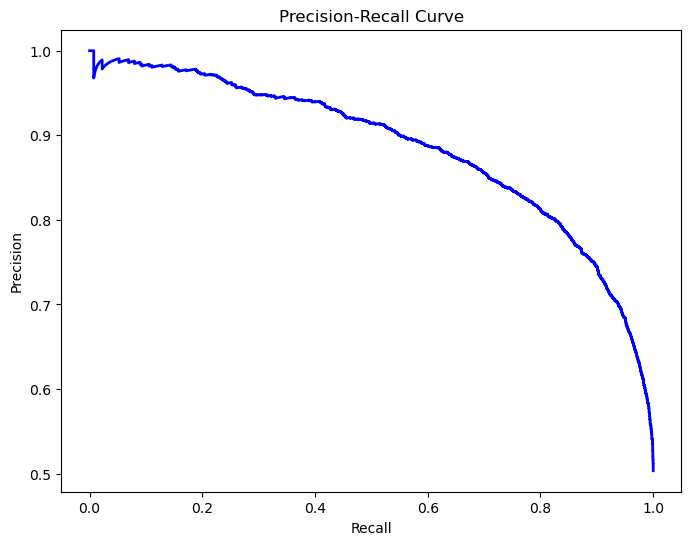

In [15]:
from sklearn.metrics import precision_recall_curve

# Compute Precision-Recall curve
precision, recall, _ = precision_recall_curve(y_test, classifier.predict_proba(X_test)[:, 1])

# Plot Precision-Recall curve
plt.figure(figsize=(8, 6))
plt.plot(recall, precision, color='blue', lw=2)
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.show()


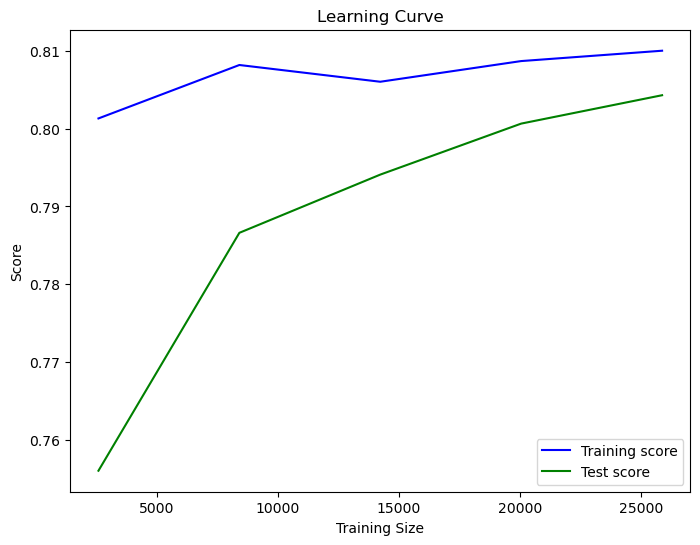

In [16]:
from sklearn.model_selection import learning_curve

# Generate learning curves
train_sizes, train_scores, test_scores = learning_curve(classifier, X_train, y_train, cv=5, n_jobs=-1)

# Plot learning curves
plt.figure(figsize=(8, 6))
plt.plot(train_sizes, np.mean(train_scores, axis=1), label='Training score', color='blue')
plt.plot(train_sizes, np.mean(test_scores, axis=1), label='Test score', color='green')
plt.xlabel('Training Size')
plt.ylabel('Score')
plt.title('Learning Curve')
plt.legend()
plt.show()


In [17]:
!pip install wordcloud matplotlib



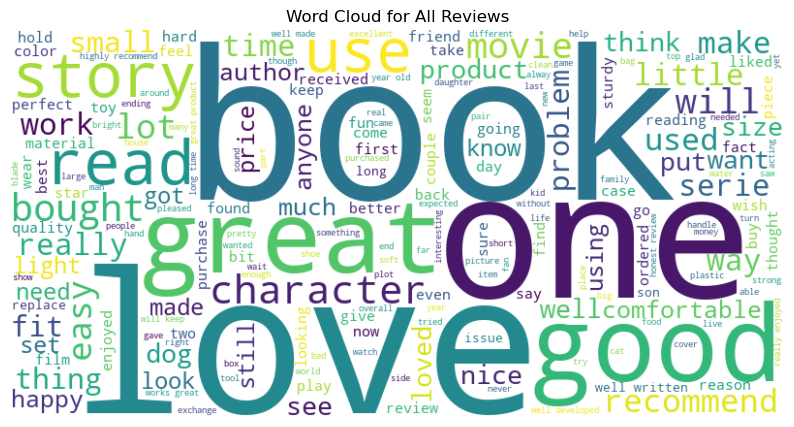

In [18]:
from wordcloud import WordCloud
import matplotlib.pyplot as plt

# Combine all text into a single string
all_reviews = ' '.join(df['cleaned_text'].values)

# Generate the word cloud
wordcloud = WordCloud(width=800, height=400, background_color='white', max_words=200).generate(all_reviews)

# Plot the word cloud
plt.figure(figsize=(10, 6))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')  # Turn off the axis
plt.title('Word Cloud for All Reviews')
plt.show()


In [19]:
# Check the first few rows of the filtered data
print(df[df['label'] == 'Fake']['cleaned_text'].head())
print(df[df['label'] == 'Real']['cleaned_text'].head())

# Check the length of the filtered reviews
print(f"Number of fake reviews: {len(df[df['label'] == 'Fake'])}")
print(f"Number of real reviews: {len(df[df['label'] == 'Real'])}")


Series([], Name: cleaned_text, dtype: object)
Series([], Name: cleaned_text, dtype: object)
Number of fake reviews: 0
Number of real reviews: 0


In [20]:
# Concatenate all fake reviews into a single string
fake_reviews = ' '.join(df[df['label'] == 'Fake']['cleaned_text'].dropna())

# Concatenate all real reviews into a single string
real_reviews = ' '.join(df[df['label'] == 'Real']['cleaned_text'].dropna())

# Generate word clouds for fake reviews
fake_wordcloud = WordCloud(width=800, height=400, background_color='white', max_words=200).generate(fake_reviews)

# Generate word clouds for real reviews
real_wordcloud = WordCloud(width=800, height=400, background_color='white', max_words=200).generate(real_reviews)

# Plot both word clouds side by side
fig, axes = plt.subplots(1, 2, figsize=(16, 8))

# Plot fake review word cloud
axes[0].imshow(fake_wordcloud, interpolation='bilinear')
axes[0].axis('off')  # Turn off axis
axes[0].set_title('Word Cloud for Fake Reviews')

# Plot real review word cloud
axes[1].imshow(real_wordcloud, interpolation='bilinear')
axes[1].axis('off')  # Turn off axis
axes[1].set_title('Word Cloud for Real Reviews')

plt.tight_layout()
plt.show()


ValueError: We need at least 1 word to plot a word cloud, got 0.